
   $$
   \frac{\partial \omega}{\partial t}
     + u\,\frac{\partial \omega}{\partial x}
     + v\,\frac{\partial \omega}{\partial y}
   = \nu\!\Bigl(\frac{\partial^2 \omega}{\partial x^2}
               +\frac{\partial^2 \omega}{\partial y^2}\Bigr),
   $$  


   $$
   \Delta\psi = -\,\omega, 
   \quad u = -\frac{\partial \psi}{\partial y}, 
   \quad v = \frac{\partial \psi}{\partial x}.
   $$  

  $$
  \omega(x,y,0) = -2 \cos x\,\cos y.
  $$
  $$
  \omega(0,y,t)=\omega(2\pi,y,t), 
  \quad 
  \omega(x,0,t)=\omega(x,2\pi,t).
  $$
  $$(x,y)\in[0,2\pi]\times[0,2\pi],\quad t\ge0.$$


In [1]:
# =============
# CARGA DE LIBRERIAS

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

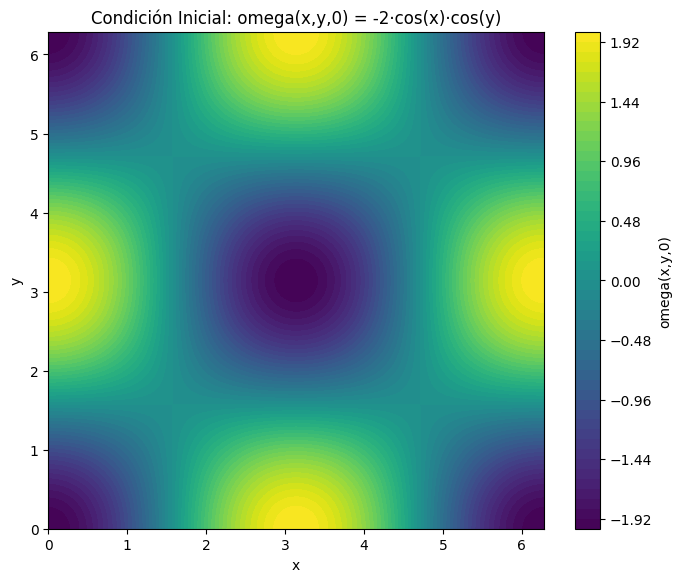

In [2]:
# Parametros del dominio
Nx, Ny = 200, 200
DOMAIN = 2 * np.pi

# Malla espacial en [0,2pi]×[0,2pi]
x = np.linspace(0, DOMAIN, Nx)
y = np.linspace(0, DOMAIN, Ny)
X, Y = np.meshgrid(x, y)

# Condicion inicial de vorticidad
omega0 = -2 * np.cos(X) * np.cos(Y)

# Representacion grafica
plt.figure(figsize=(8, 6.45))
cs = plt.contourf(X, Y, omega0, levels=50, cmap='viridis')
plt.colorbar(cs, label='omega(x,y,0)')
plt.title('Condición Inicial: omega(x,y,0) = -2·cos(x)·cos(y)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.xlim(0, DOMAIN)
plt.ylim(0, DOMAIN)

plt.show()

In [3]:
# =============
# DEFINICION DEL MODELO

def gradients(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
nu = 0.1                           # viscosidad cinematica ν
DOMAIN = 2 * torch.pi              # dominio [0,2pi] en x,y
T_MAX = 1.0                        # tiempo maximo
N_STEPS = 2500                     # iteraciones de entrenamiento
N_COLLOC = 25000                   # puntos collocation para PDE
N_BC = 25000                       # puntos para condiciones de frontera e iniciales

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para aproximar Psi(x,y,t)
class NAVIER(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)
    
# class NAVIER(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(3, layers[0]),
#             nn.ReLU(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)
# 
# class NAVIER(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(3, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = NAVIER([50,50,50,50,50,50]).to(device)
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [4]:
# =============
# BUCLE DE ENTRENAMIENTO

# Parametros
EXTRA_EPOCHS = 0
lambda_ic    = 1000
lambda_bc    = 10
# lambda_ic    = 1
# lambda_bc    = 1
model_path   = 'models/stokes/lambdas/taylor_green'
os.makedirs(model_path, exist_ok=True)

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        # Puntos collocation (x,y,t) ∈ [0,2pi]^2 x [0,T_MAX]
        xy = torch.rand(N_COLLOC,2, device=device) * DOMAIN
        t  = torch.rand(N_COLLOC,1, device=device) * T_MAX
        X  = torch.cat([xy, t], dim=1).requires_grad_(True)

        # Prediccion de Psi y cálculo de u,v,omega
        psi = mlp(X).squeeze()
        grads = gradients(psi, X)
        psi_x, psi_y, psi_t = grads[:,0], grads[:,1], grads[:,2]
        u = -psi_y
        v =  psi_x
        omega = gradients(v, X)[:,0] - gradients(u, X)[:,1]

        # Residuo de la PDE de vorticidad
        omega_t = gradients(omega, X)[:,2]
        omega_x = gradients(omega, X)[:,0]
        omega_y = gradients(omega, X)[:,1]
        lap_omega = gradients(omega_x, X)[:,0] + gradients(omega_y, X)[:,1]
        pde_res = omega_t + u*omega_x + v*omega_y - nu*lap_omega
        loss_pde = mse(pde_res, torch.zeros_like(pde_res))

        # Condicion inicial
        xy0 = torch.rand(N_BC,2, device=device) * DOMAIN
        t0  = torch.zeros(N_BC,1, device=device, requires_grad=True)
        X0  = torch.cat([xy0, t0], dim=1)
        psi0 = mlp(X0).squeeze()
        u0 = -gradients(psi0, X0)[:,1]
        v0 =  gradients(psi0, X0)[:,0]
        omega0_hat = gradients(v0, X0)[:,0] - gradients(u0, X0)[:,1]
        omega0 = -2 * torch.cos(xy0[:,0]) * torch.cos(xy0[:,1])
        loss_ic = lambda_ic*mse(omega0_hat, omega0)

        # Condiciones de contorno periodicas
        xb = torch.rand(N_BC,1,device=device)*DOMAIN
        yb = torch.rand(N_BC,1,device=device)*DOMAIN
        tb = torch.rand(N_BC,1,device=device)*T_MAX
        # frontera x=0 vs x=2pi
        Xb1 = torch.cat([torch.zeros_like(xb), yb, tb], dim=1).requires_grad_(True)
        Xb2 = torch.cat([DOMAIN*torch.ones_like(xb), yb, tb], dim=1).requires_grad_(True)
        # frontera y=0 vs y=2pi
        Xb3 = torch.cat([xb, torch.zeros_like(yb), tb], dim=1).requires_grad_(True)
        Xb4 = torch.cat([xb, DOMAIN*torch.ones_like(yb), tb], dim=1).requires_grad_(True)
        psi_b1 = mlp(Xb1).squeeze(); psi_b2 = mlp(Xb2).squeeze()
        psi_b3 = mlp(Xb3).squeeze(); psi_b4 = mlp(Xb4).squeeze()
        loss_bc = lambda_bc*(mse(psi_b1, psi_b2) + mse(psi_b3, psi_b4))

        # Paso de optimizacion
        loss = loss_pde + loss_ic + loss_bc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "ic":  f"{loss_ic.item():.2e}",
            "bc":  f"{loss_bc.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e} — lr: {optimizer.param_groups[0]['lr']}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_ic': loss_ic/lambda_ic,
        'loss_bc': loss_bc/lambda_bc
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

Cargado checkpoint de la época 10.
Entrenamiento completado.


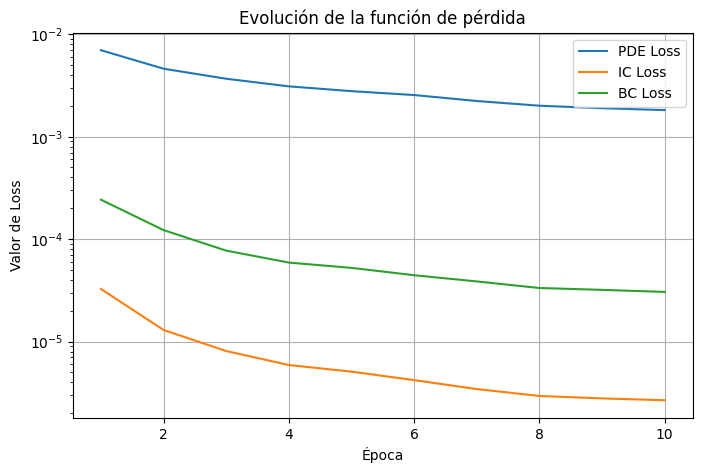

In [5]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

# Definir ruta y buscar archivos de checkpoint
model_path   = 'models/stokes/lambdas/taylor_green'
checkpoint_pattern = f"{model_path}_*.pth"
checkpoint_files = sorted(glob.glob(checkpoint_pattern))

# Preparar listas para almacenar datos
epochs    = []
loss_pde  = []
loss_ic   = []
loss_bc   = []

# Recorrer cada archivo y extraer la información
device = 'cpu'
for ckpt_file in checkpoint_files:
    ckpt = torch.load(ckpt_file, map_location=device)
    epoch_num = ckpt['epoch'] - 1
    epochs.append(epoch_num)
    loss_pde.append(ckpt['loss_pde'].item())
    loss_ic.append(ckpt['loss_ic'].item())
    loss_bc.append(ckpt['loss_bc'].item())

# Graficar las curvas de perdida
plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.plot(epochs, loss_pde, label='PDE Loss')
plt.plot(epochs, loss_ic,  label='IC Loss')
plt.plot(epochs, loss_bc,  label='BC Loss')
plt.xlabel('Época')
plt.ylabel('Valor de Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()
plt.grid(True)
plt.show()

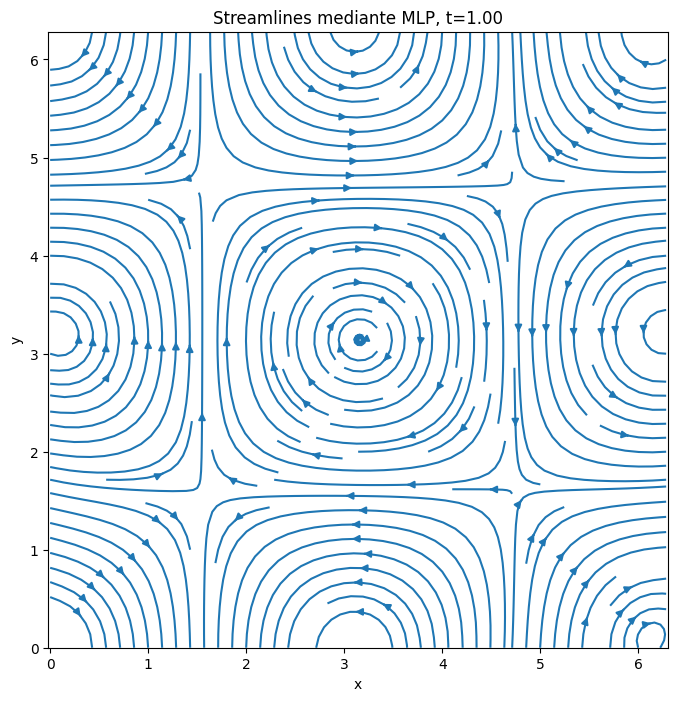

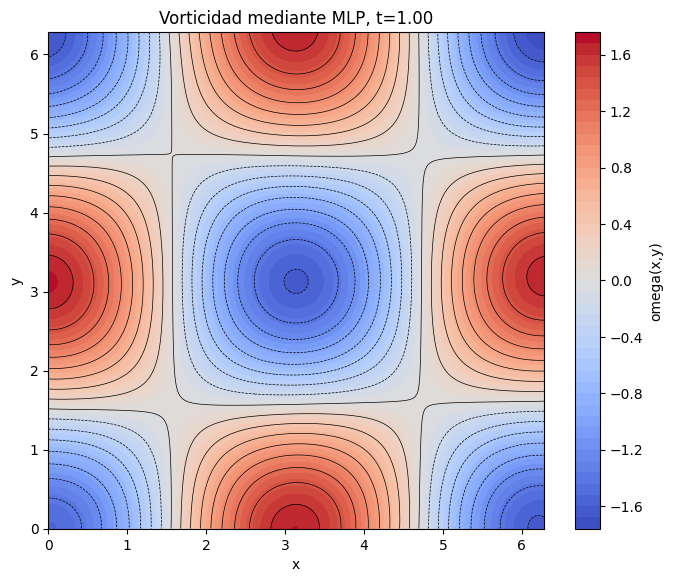

In [ ]:
# =============
# REPRESENTACION DE LA SOLUCION EXACTA

# Parametros
t = 1.0                   # instante de tiempo a visualizar
Nx, Ny = 200, 200         # resolucion de la malla en x,y

mlp.eval()
mlp.cpu()

# Generacion de la malla
x = np.linspace(0, 2*np.pi, Nx)
y = np.linspace(0, 2*np.pi, Ny)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.ravel(), Y.ravel()], axis=1)
T  = np.full((XY.shape[0],1), t)
inp = np.hstack([XY, T])
inp_tensor = torch.from_numpy(inp).float()
inp_tensor.requires_grad_(True)

# Calculo de psi y sus gradientes
psi = mlp(inp_tensor).squeeze()
grads = gradients(psi, inp_tensor)
psi_x = grads[:, 0]  # ∂Ψ/∂x
psi_y = grads[:, 1]  # ∂Ψ/∂y
u = -psi_y
v =  psi_x

# Calculo de la vorticidad omega
u_grads = gradients(u, inp_tensor)
v_grads = gradients(v, inp_tensor)
du_dy = u_grads[:, 1]
dv_dx = v_grads[:, 0]
omega = dv_dx - du_dy

# Reformateo para graficar
u_plot = u.detach().numpy().reshape(Ny, Nx)
v_plot = v.detach().numpy().reshape(Ny, Nx)
omega_plot = omega.detach().numpy().reshape(Ny, Nx)

# Streamlines
plt.figure(figsize=(8,8))
plt.streamplot(X, Y, u_plot, v_plot, density=1.5)
plt.title(f'Streamlines mediante MLP, t={t:.2f}')
plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal')
plt.show()

# Grafica de contornos de vorticidad
plt.figure(figsize=(8, 6.45))
cs = plt.contourf(X, Y, omega_plot, levels=50, cmap='coolwarm')
plt.colorbar(cs, label='omega(x,y)')
plt.contour(X, Y, omega_plot, levels=20, colors='k', linewidths=0.5)
plt.title(f'Vorticidad mediante MLP, t={t:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

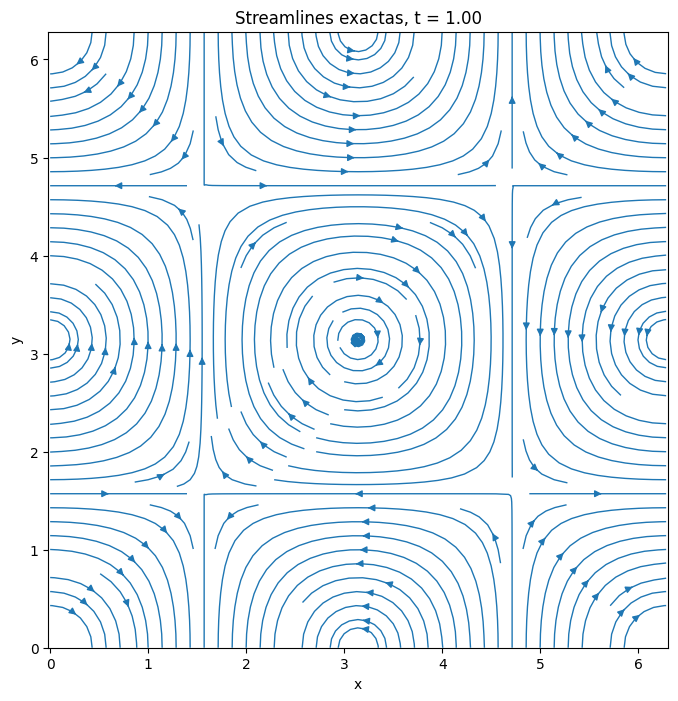

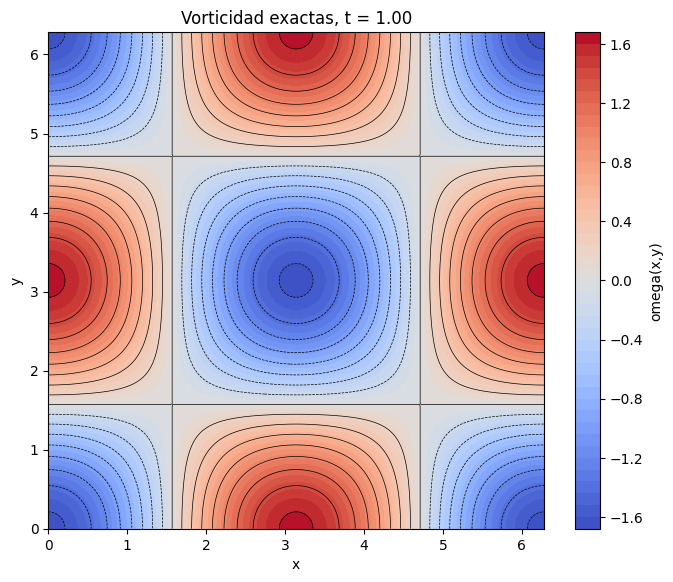

In [ ]:
# =============
# REPRESENTACION DEL PERFIL 2D REAL

# Parametros fisicos y de visualizacion
nu = 0.1                # viscosidad cinematica
t = 1.0                 # instante de tiempo a visualizar
Nx, Ny = 200, 200       # resolucion de la malla en x,y

# Creamos la malla regular en [0,2pi]×[0,2pi]
x = np.linspace(0, 2*np.pi, Nx)
y = np.linspace(0, 2*np.pi, Ny)
X, Y = np.meshgrid(x, y)

# Evaluamos la solucion analitica u(x,y,t), v(x,y,t)
factor = np.exp(-2 * nu * t)
u =  np.cos(X) * np.sin(Y) * factor
v = -np.sin(X) * np.cos(Y) * factor

# Calculo de la vorticidad omega
omega = -2 * np.cos(X) * np.cos(Y) * factor

# Streamlines
plt.figure(figsize=(8,8))
plt.streamplot(X, Y, u, v, density=1.5, linewidth=1, arrowsize=1)
plt.title(f'Streamlines exactas, t = {t:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

# Grafica de contornos de vorticidad
plt.figure(figsize=(8, 6.45))
cs = plt.contourf(X, Y, omega, levels=50, cmap='coolwarm')
plt.colorbar(cs, label='omega(x,y)')
plt.contour(X, Y, omega, levels=20, colors='k', linewidths=0.5)
plt.title(f'Vorticidad exactas, t = {t:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

# Tiempos en los que evaluar la vorticidad
times = [0, 0.25, 0.5, 0.75, 1.0]  
mses_omega = []

for ti in times:
    # Construccion de la entrada
    T_arr = np.full((XY.shape[0], 1), ti)
    inp_t = torch.from_numpy(np.hstack([XY, T_arr])).float()
    inp_t.requires_grad_(True)

    # Evaluacion
    psi_t = mlp(inp_t).squeeze()

    # Gradientes y vorticidad
    grads_t  = gradients(psi_t, inp_t)
    psi_x_t  = grads_t[:, 0]
    psi_y_t  = grads_t[:, 1]
    u_t = -psi_y_t
    v_t =  psi_x_t
    du_dy = gradients(u_t, inp_t)[:, 1]
    dv_dx = gradients(v_t, inp_t)[:, 0]
    omega_t = (dv_dx - du_dy).detach().numpy().reshape(Ny, Nx)

    # Solucion exacta
    omega_exact_t = -2 * np.cos(X) * np.cos(Y) * np.exp(-0.2 * ti)

    # Error MSE
    mse_t = mean_squared_error(omega_exact_t.ravel(), omega_t.ravel())
    mses_omega.append((ti, mse_t))

# Impresion de resultados
for ti, mse in mses_omega:
    print(f"t = {ti:.2f}, MSE_omega = {mse:.3e}")

t = 0.00, MSE_omega = 2.872e-06
t = 0.25, MSE_omega = 2.247e-04
t = 0.50, MSE_omega = 5.425e-04
t = 0.75, MSE_omega = 7.768e-04
t = 1.00, MSE_omega = 1.066e-03
